In [1]:
import datetime as dt
import os
import sys
import sqlalchemy as sa
import pandas as pd
import numpy as np

In [2]:
# Setup connection parameters
comp = os.environ["COMPUTERNAME"]  # Get the computer name from environment variables
dbase = "Financial_Securities"     # Define the name of the database

username = os.getlogin()
external_folder_path = 'C:/Users/' + username + '/Documents/Projects/Financial_Securities/Custom_Python_Functions'
sys.path.append(external_folder_path)
from custom_python_functions import create_connection, get_pricing_data, calculate_return, calculate_portfolio_return
from custom_python_functions import calculate_drawdowns, plot_returns_line_chart, plot_period_returns_by_ticker_box_plot
from custom_python_functions import plot_return_histogram, plot_returns_bubble_chart, plot_ticker_correlations

# Create a connection to the database
s, e = create_connection(comp, dbase, "", "")
s1 = s()  # Instantiate a session object

In [3]:
# Define SQL query to retrieve tickers from the Yahoo_Equity_Prices table
sql_stat = """SELECT 
        TRIM(q2.Ticker) AS Ticker,
        q1.Date,
        ROUND(q1.[Open], 2) AS "Open",
        ROUND(q1.[High], 2) AS "High",
        ROUND(q1.[Low], 2) AS "Low",
        ROUND(q1.[Close], 2) AS "Close",
        q1.Volume AS "Volume"
FROM [Financial_Securities].[Equities].[Yahoo_Equity_Prices] q1
INNER JOIN [Financial_Securities].[Equities].[Equities] q2
ON q1.Ticker_ID = q2.Ticker_ID
ORDER BY q2.Ticker, q1.Date
"""

try:
    # Execute the SQL query and read the results into a DataFrame
    df_pricing = pd.read_sql(sql_stat, s1.bind)
    
except sa.exc.SQLAlchemyError as e:
    # Handle exceptions during SQL query execution
    print(f"Issue querying database tables! Error: {e}")
    s1.close()
    raise

In [4]:
if df_pricing.empty:
    raise ValueError("DataFrame is empty after SQL query.")
    
df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])
df_pricing['Year'] = df_pricing['Date'].dt.year


In [5]:
# Determine the first date for each ticker
first_dates = df_pricing.groupby('Ticker')['Date'].min().reset_index()
first_dates.rename(columns={'Date': 'First Date'}, inplace=True)

# Count how many tickers share the same first date
count_first_dates = first_dates['First Date'].value_counts().reset_index()
count_first_dates.columns = ['First Date', 'Count']

# Filter for first dates that occur more than once and take the min date
valid_first_dates = count_first_dates[count_first_dates['Count'] > 1]['First Date']
min_valid_first_date = valid_first_dates.min()

# Merge back to keep only those tickers with the same first date
df_pricing_filtered = df_pricing.merge(first_dates, on='Ticker', suffixes=('', '_y'))  # Specify suffixes here
df_pricing_filtered = df_pricing_filtered[df_pricing_filtered['First Date'].isin([min_valid_first_date])].copy()

df_pricing_filtered.drop(columns=['First Date'], inplace=True)
    
if 'First Date_y' in df_pricing_filtered.columns:
    df_pricing_filtered.drop(columns=['First Date_y'], inplace=True)
    
df_pricing_filtered.sort_values(by=['Ticker', 'Date'], inplace=True)

# Show count of original Tickers
ticker_cnt = len(df_pricing['Ticker'].unique())
ticker_cnt2 = len(df_pricing_filtered['Ticker'].unique())
print(f'Original Ticker list count: {ticker_cnt}')
print(f'Filtered Ticker list count: {ticker_cnt2}')



Original Ticker list count: 503
Filtered Ticker list count: 496


In [6]:
two_years_after_min_date = min_valid_first_date + pd.DateOffset(days=(365)*2)
two_years_after_min_date_str = two_years_after_min_date.strftime('%Y-%m-%d')

period_label = 'Daily'
date_filter = (df_pricing_filtered['Date'] < two_years_after_min_date_str)
df_pricing_second_year = df_pricing_filtered.loc[date_filter].copy()  # Adding .copy() here to avoid the warning
df_pricing_second_year.sort_values(by=['Ticker', 'Date'], inplace=True)
df_ret_second_year = calculate_return(df_pricing_second_year.copy(), 'Daily')
df_ret_second_year.sort_values(by=['Ticker', 'Date'], inplace=True)


In [7]:
df_ret_second_year_last = df_ret_second_year.copy().groupby('Ticker').tail(1)

risk_free_rate = 1.5
df_ret_second_year_last['Annualized Sortino Ratio'] = np.where(
    df_ret_second_year_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_second_year_last['Annualized % Return'] - risk_free_rate) / df_ret_second_year_last['Annualized Downside Volatility'], 2)
)

df_ret_second_year_last['Annualized Sortino Ratio Rank'] = df_ret_second_year_last.groupby('Date')['Annualized Sortino Ratio'].rank(ascending=False).astype(int)
num_of_ranks = 10
df_ret_second_year_last_top = df_ret_second_year_last[df_ret_second_year_last['Annualized Sortino Ratio Rank'] <= num_of_ranks].copy()


In [8]:
portfolio_tickers = df_ret_second_year_last_top['Ticker'].unique()
print(portfolio_tickers)

df_portfolio_tickers_ret_second_year = df_ret_second_year[df_ret_second_year['Ticker'].isin(portfolio_tickers)].copy()
ticker_cnt = len(df_portfolio_tickers_ret_second_year['Ticker'].unique())
print(f'Portfolio list count: {ticker_cnt}')


['AZO' 'DVN' 'HES' 'LLY' 'MCK' 'MPC' 'MRO' 'OXY' 'TRGP' 'XOM']
Portfolio list count: 10


In [9]:
df_portfolio_ret_second_year = calculate_portfolio_return(df_portfolio_tickers_ret_second_year.copy(), 'Daily')
df_portfolio_ret_second_year['Ticker'] = 'PFL'
df_portfolio_ret_second_year.sort_values(by=['Date'], inplace=True)


In [10]:
df_ret_second_year_comb = pd.concat([df_portfolio_tickers_ret_second_year, df_portfolio_ret_second_year], axis=0)
df_ret_second_year_comb.sort_values(by=['Ticker','Date'], inplace=True)
plot_returns_line_chart(df_ret_second_year_comb, 'Daily', 'Cumulative % Return')


In [11]:
df_ret_second_year_comb_last = df_ret_second_year_comb.copy().groupby('Ticker').tail(1)

risk_free_rate = 1.5
df_ret_second_year_comb_last['Annualized Sortino Ratio'] = np.where(
    df_ret_second_year_comb_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_second_year_comb_last['Annualized % Return'] - risk_free_rate) / df_ret_second_year_comb_last['Annualized Downside Volatility'], 2)
)
df_ret_second_year_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)


In [12]:
df_ret_second_year_comb_last = df_ret_second_year_comb_last[['Ticker', 'Date', 'Annualized % Return', 'Annualized Sortino Ratio']]
df_ret_second_year_comb_last.sort_values(by=['Annualized Sortino Ratio'], ascending=False, inplace=True)

print(df_ret_second_year_comb_last.to_string(index=False))


Ticker       Date  Annualized % Return  Annualized Sortino Ratio
   MCK 2023-01-03                45.88                      3.07
   PFL 2023-01-03                61.54                      3.04
   MRO 2023-01-03                91.64                      2.86
   OXY 2023-01-03                83.30                      2.63
   LLY 2023-01-03                45.88                      2.46
   MPC 2023-01-03                59.99                      2.38
   XOM 2023-01-03                55.64                      2.21
  TRGP 2023-01-03                59.06                      2.19
   AZO 2023-01-03                43.32                      2.18
   DVN 2023-01-03                82.41                      2.16
   HES 2023-01-03                56.32                      2.12


In [13]:
df_ret_second_year_comb2 = pd.concat([df_ret_second_year_last, df_portfolio_ret_second_year], axis=0)
df_ret_second_year_comb2.sort_values(by=['Ticker','Date'], inplace=True)

df_ret_second_year_comb2_last = df_ret_second_year_comb2.copy().groupby('Ticker').tail(1)

risk_free_rate = 1.5
df_ret_second_year_comb2_last['Annualized Sortino Ratio'] = np.where(
    df_ret_second_year_comb2_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_second_year_comb2_last['Annualized % Return'] - risk_free_rate) / df_ret_second_year_comb2_last['Annualized Downside Volatility'], 2)
)
df_ret_second_year_comb2_last.sort_values(by=['Ticker'], ascending=True, inplace=True)

plot_returns_bubble_chart(df_ret_second_year_comb2_last, 'Annualized % Return', 'Annualized Sortino Ratio')


In [27]:
date_filter2 = (df_pricing_filtered['Date'] >= two_years_after_min_date_str)
df_pricing_after_second_year = df_pricing_filtered.loc[date_filter2].copy()  # Adding .copy() here to avoid the warning

df_ret_after_second_year = calculate_return(df_pricing_after_second_year.copy(), 'Daily')
df_portfolio_tickers_ret_after_second_year = df_ret_after_second_year[df_ret_after_second_year['Ticker'].isin(portfolio_tickers)].copy()

df_portfolio_ret_after_second_year = calculate_portfolio_return(df_portfolio_tickers_ret_after_second_year.copy(), 'Daily')
df_portfolio_ret_after_second_year['Ticker'] = 'PFL'
df_portfolio_ret_after_second_year.sort_values(by=['Date'], inplace=True)


In [28]:
df_ret_after_second_year_comb = pd.concat([df_ret_after_second_year, df_portfolio_ret_after_second_year], axis=0)
df_ret_after_second_year_comb.sort_values(by=['Ticker','Date'], inplace=True)

In [29]:
df_ret_after_second_year_comb_last = df_ret_after_second_year_comb.copy().groupby('Ticker').tail(1)
df_ret_after_second_year_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)

risk_free_rate = 2.5
df_ret_after_second_year_comb_last['Annualized Sortino Ratio'] = np.where(
    df_ret_after_second_year_comb_last['Annualized Volatility'] == 0, 
    0, 
    round((df_ret_after_second_year_comb_last['Annualized % Return'] - risk_free_rate) / df_ret_after_second_year_comb_last['Annualized Downside Volatility'], 2)
)
df_ret_after_second_year_comb_last.sort_values(by=['Ticker'], ascending=True, inplace=True)



In [31]:
df_ret_after_second_year_comb_last['Annualized Sortino Ratio Rank'] = df_ret_after_second_year_comb_last.groupby('Date')['Annualized Sortino Ratio'].rank(ascending=False).astype(int)
df_ret_after_second_year_comb_last = df_ret_after_second_year_comb_last[['Ticker', 'Date', 'Annualized % Return', 'Annualized Sortino Ratio', 'Annualized Sortino Ratio Rank']]
df_ret_after_second_year_comb_last.sort_values(by=['Annualized Sortino Ratio Rank'], ascending=True, inplace=True)

num_of_ranks = 10
df_ret_after_second_year_comb_last_top = df_ret_after_second_year_comb_last[df_ret_after_second_year_comb_last['Annualized Sortino Ratio Rank'] <= num_of_ranks].copy()
df_ret_after_second_year_comb_last_top = df_ret_after_second_year_comb_last_top[['Ticker', 'Date', 'Annualized Sortino Ratio', 'Annualized Sortino Ratio Rank']]
df_ret_after_second_year_comb_last_top.sort_values(by=['Annualized Sortino Ratio Rank'], inplace=True)

print(df_ret_after_second_year_comb_last_top.to_string(index=False))


Ticker       Date  Annualized Sortino Ratio  Annualized Sortino Ratio Rank
  NVDA 2024-09-20                      8.25                              1
  META 2024-09-20                      6.57                              2
    GE 2024-09-20                      6.38                              3
   VST 2024-09-20                      5.34                              4
   RCL 2024-09-20                      4.88                              5
   PHM 2024-09-20                      4.67                              6
  FICO 2024-09-20                      4.60                              7
   TDG 2024-09-20                      4.13                              8
   HWM 2024-09-20                      4.05                              9
  UBER 2024-09-20                      4.03                             10


In [32]:
df_ret_after_second_year_comb_last['Annualized Sortino Ratio Percentile Rank'] = round((1.00 - df_ret_after_second_year_comb_last.groupby('Date')['Annualized Sortino Ratio'].rank(pct=True, ascending=False)) * 100, 0).astype(int)
df_ret_after_second_year_comb_last = df_ret_after_second_year_comb_last[['Ticker', 'Date', 'Annualized % Return', 'Annualized Sortino Ratio', 'Annualized Sortino Ratio Percentile Rank']]
df_ret_after_second_year_comb_last.sort_values(by=['Annualized Sortino Ratio Percentile Rank'], ascending=False, inplace=True)

df_ret_after_second_year_comb_last_ticker = df_ret_after_second_year_comb_last[df_ret_after_second_year_comb_last['Ticker'] == 'PFL'].copy()

print(df_ret_after_second_year_comb_last_ticker.to_string(index=False))


Ticker       Date  Annualized % Return  Annualized Sortino Ratio  Annualized Sortino Ratio Percentile Rank
   PFL 2024-09-20                14.99                      1.15                                        70


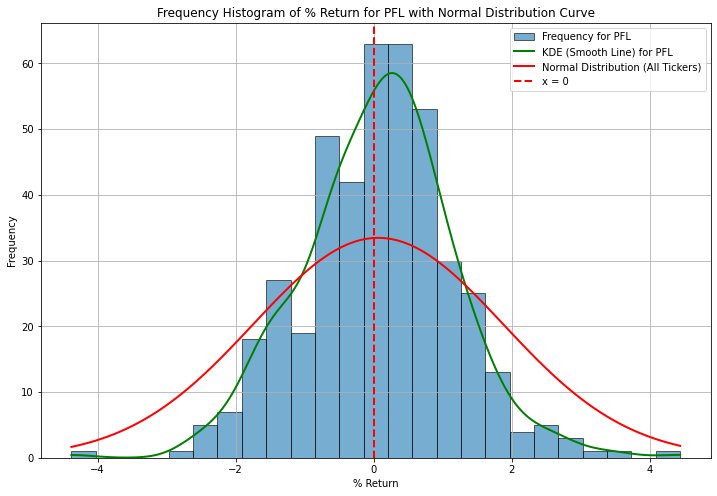

In [35]:
plot_return_histogram(df_ret_after_second_year_comb, '% Return', 'PFL')

In [36]:
df_bench_ret_after_second_year = calculate_portfolio_return(df_ret_after_second_year.copy(), 'Daily')
df_bench_ret_after_second_year['Ticker'] = 'BM'
df_bench_ret_after_second_year.sort_values(by=['Date'], inplace=True)


In [37]:
df_ret_after_second_year_comb2 = pd.concat([df_bench_ret_after_second_year, df_portfolio_ret_after_second_year], axis=0)
df_ret_after_second_year_comb2.sort_values(by=['Ticker','Date'], inplace=True)
plot_returns_line_chart(df_ret_after_second_year_comb2, 'Daily', 'Cumulative % Return')
                                          

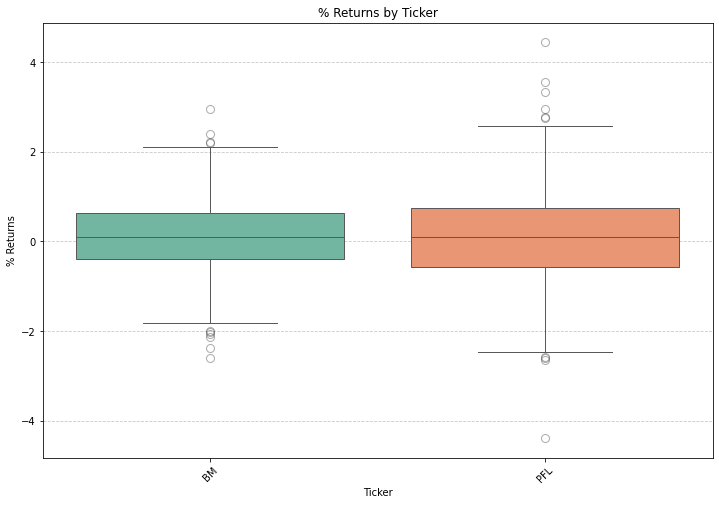

In [38]:
plot_period_returns_by_ticker_box_plot(df_ret_after_second_year_comb2, 'Daily')


In [40]:
df_pricing_mth = get_pricing_data(df_pricing_filtered.copy(), 'Month')
date_filter3 = (df_pricing_mth['Date'] >= two_years_after_min_date_str)
df_pricing_mth_after_second_year = df_pricing_mth.loc[date_filter3].copy()

df_ret_mth_after_second_year = calculate_return(df_pricing_mth_after_second_year.copy(), 'Month')
df_ret_mth_after_second_year.sort_values(by=['Ticker', 'Date'], inplace=True)


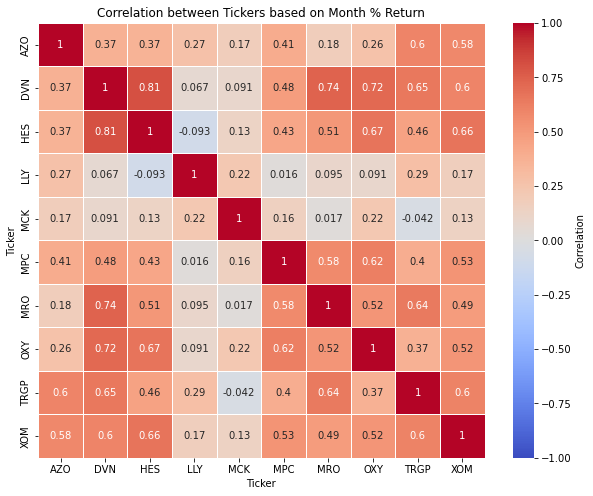

Ticker,AZO,DVN,HES,LLY,MCK,MPC,MRO,OXY,TRGP,XOM
Ticker,,,,,,,,,,
AZO,1.000000,0.370938,0.365746,0.270273,0.174597,0.405464,0.177058,0.264150,0.599951,0.582456
DVN,0.370938,1.000000,0.809630,0.066956,0.090585,0.478865,0.740622,0.718735,0.654264,0.597611
HES,0.365746,0.809630,1.000000,-0.092845,0.129918,0.434353,0.514996,0.669647,0.456760,0.664921
LLY,0.270273,0.066956,-0.092845,1.000000,0.224510,0.016374,0.094823,0.091093,0.287891,0.165712
MCK,0.174597,0.090585,0.129918,0.224510,1.000000,0.155858,0.016915,0.221972,-0.041562,0.134611
MPC,0.405464,0.478865,0.434353,0.016374,0.155858,1.000000,0.576004,0.621795,0.396218,0.525316
MRO,0.177058,0.740622,0.514996,0.094823,0.016915,0.576004,1.000000,0.522244,0.641164,0.491586
OXY,0.264150,0.718735,0.669647,0.091093,0.221972,0.621795,0.522244,1.000000,0.368279,0.517287
TRGP,0.599951,0.654264,0.456760,0.287891,-0.041562,0.396218,0.641164,0.368279,1.000000,0.602859


In [41]:
df_portfolio_tickers_ret_mth_after_second_year = df_ret_mth_after_second_year[df_ret_mth_after_second_year['Ticker'].isin(portfolio_tickers)].copy()
plot_ticker_correlations(df_portfolio_tickers_ret_mth_after_second_year, 'Month % Return')


In [42]:
s1.close()
